In [ ]:
# Can a network see a single pixel?


In [1]:
%pylab inline

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args([])

Populating the interactive namespace from numpy and matplotlib


In [2]:
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [167]:
from sklearn.model_selection import train_test_split


z = 1
n_samples = 1000
s=.25
blob_size = 1
blob_offset= 1
def generateData(n_samples=1000,s=.25,z=5):
    y = np.random.rand(n_samples)<.5
    X = (np.random.rand(n_samples,3,32,32)-.5)/float(z)
    for i,yy in enumerate(y):
        
        if yy == 0:
            X[i,:,5:5+blob_size,5:5+blob_size]=s
        else:
            X[i,:,5+blob_offset:5+blob_offset+blob_size,5+blob_offset:5+blob_offset+blob_size]=s
    return X,y


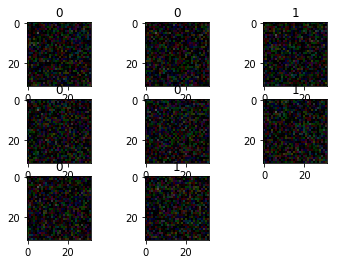

In [175]:
X,y = generateData(n_samples=5000,s=.3,z=2)

X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train.astype(float))
y_test = torch.LongTensor(y_test.astype(float))

train_data = torch.utils.data.TensorDataset(X_train,y_train)
test_data = torch.utils.data.TensorDataset(X_test,y_test)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=args.test_batch_size, shuffle=True, **kwargs)
#X,y = generateData(n_samples=1000,s=.5,z=1)

for j in range(8):
    subplot(3,3,j+1)
    imshow(X_train[j,:,:,:].numpy().transpose(1,2,0))
    title(y_train[j])

In [176]:
 
if False:
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/home/amir/mnist', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/home/amir/mnist', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [177]:

args.log_interval=100

In [178]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x)+x[:,:,2:-2,2:-2], 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
       
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        #return F.log_softmax(x, dim=1)

In [186]:
32*32

1024

In [187]:
class fcnet(nn.Module):
    def __init__(self):
        super(fcnet,self).__init__()
        self.fc = nn.Linear(1024*3,10)
    def forward(self, x):#
        x = x.view(-1,1024*3)
        return self.fc(x)

In [190]:
#del = Net()

from models.cifar.densenet import densenet
#d=densenet()
#model = fcnet()
model = densenet() 
if args.cuda:
    model.cuda()
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
optimizer = optim.SGD(model.parameters(),lr=.1,momentum=.9)
args.log_interval=50
args.epochs=5
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
args.epochs=10
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test()

not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
not doing any inhibition
Train Epoch: 1 [0/3750 (0%)]	Loss: 2.157252
Train Epoch: 1 [3200/3750 (85%)]	Loss: 0.705325

Test set: Average loss: 0.0011, Accuracy: 642/1250 (51%)

Train Epoch: 2 [0/3750 (0%)]	Loss: 0.712024
Train Epoch: 2 [3200/3750 (85%)]	Loss: 0.788477

Test set: Average loss: 0.0011, Accuracy: 651/1250 (52%)

Train Epoch: 3 [0/3750 (0%)]	Loss: 0.679092
Train Epoch: 3 [3200/3750 (85%)]	Loss: 0.351665

Test set: Average loss: 0.0124, Accuracy: 647/1250 (52%)

Train Epoch: 4 [0/3750 (0%)]	Loss: 0.061454
Train Epoch: 4 [3200/3750 (8

Process Process-338:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()


KeyboardInterrupt: 

In [164]:
nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5,padding=0)(Variable(torch.zeros(1,1,28,28))).shape

torch.Size([1, 1, 24, 24])

In [165]:
output#

NameError: name 'output' is not defined

In [ ]:
F.nll_loss(output,target)

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)